# 01 Laden der Daten des von Hartwig ausgesuchten Beispielfalls

Die Daten sollten unter /vols/satellite/home/hartwig/ci_case_hrv/ liegen.

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import MSGtools as mst
from analysis_tools import grid_and_interpolation as gi
from analysis_tools import make_hrv_upscaling as mhu
from io_tools import radolan
from standard_config import *

/vols/satellite/home/lenk/anaconda3/envs/tracking/lib/python3.7/site-packages/xarray/core/merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


In [2]:
data_path = "/vols/satellite/home/hartwig/ci_case_hrv"

In [3]:
ds1 = xr.open_dataset('{}/msg2-20130618-l2cpphr.nc'.format(data_path))
ds2 = xr.open_dataset('{}/msg2-20130618-l2cpplr.nc'.format(data_path))

In [4]:
ds1

<xarray.Dataset>
Dimensions:          (bnds: 2, time: 48, x: 101, y: 51)
Coordinates:
  * time             (time) datetime64[ns] 2013-06-18T12:00:00 ... 2013-06-18T15:55:00
  * x                (x) float32 11353.525 11356.526 ... 11650.565 11653.565
  * y                (y) float32 -2676.3596 -2673.3591 ... -2529.3398 -2526.3394
Dimensions without coordinates: bnds
Data variables:
    time_bnds        (time, bnds) datetime64[ns] ...
    cldmask          (time, y, x) float32 ...
    cot              (time, y, x) float32 ...
    cot_unc          (time, y, x) float32 ...
    cre              (time, y, x) float32 ...
    cre_unc          (time, y, x) float32 ...
    cwp              (time, y, x) float32 ...
    cwp_unc          (time, y, x) float32 ...
    cph              (time, y, x) float32 ...
    cph_pavo         (time, y, x) float32 ...
    cth              (time, y, x) float32 ...
    ctt              (time, y, x) float32 ...
    ctp              (time, y, x) float32 ...
    trs    

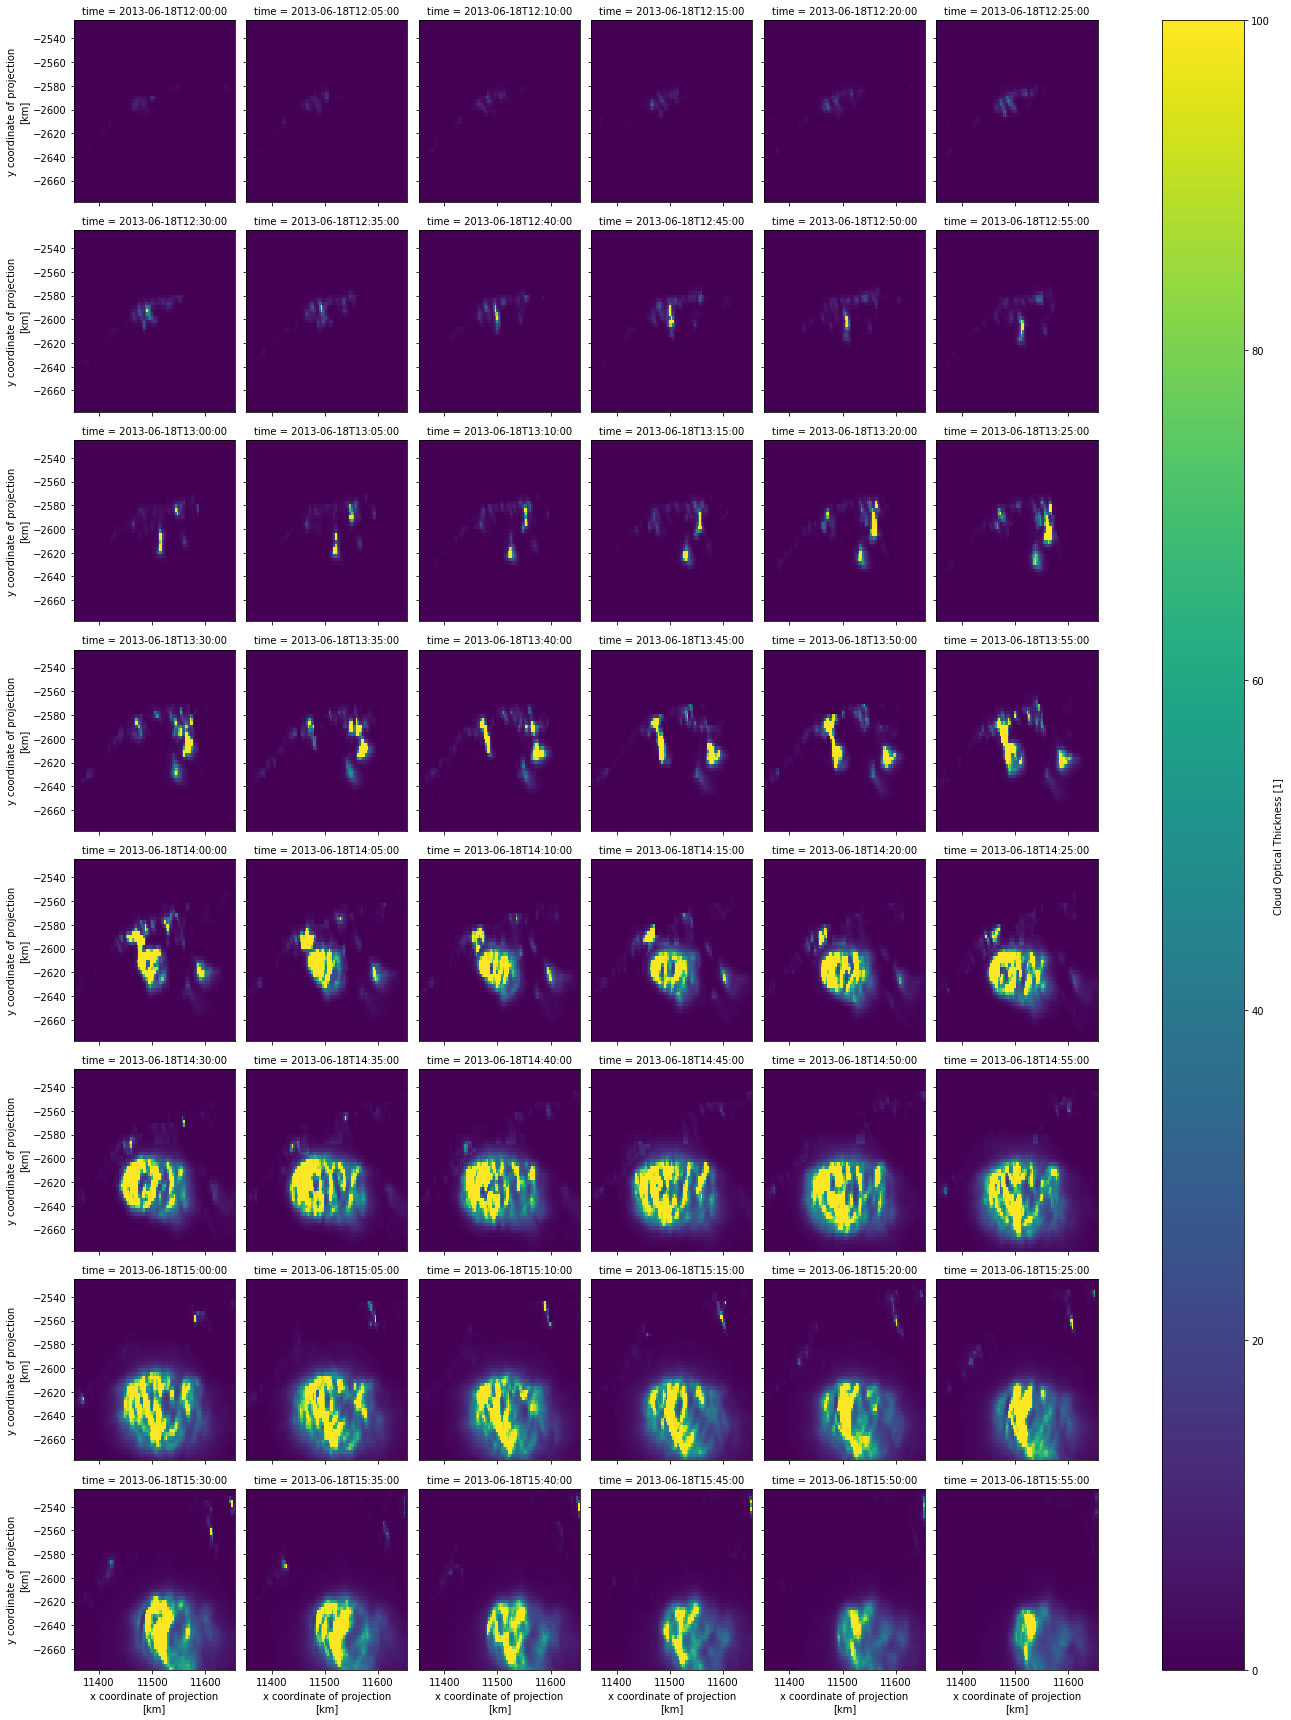

In [5]:
ds1.cot.plot(x='x',y='y',col='time',col_wrap=6)

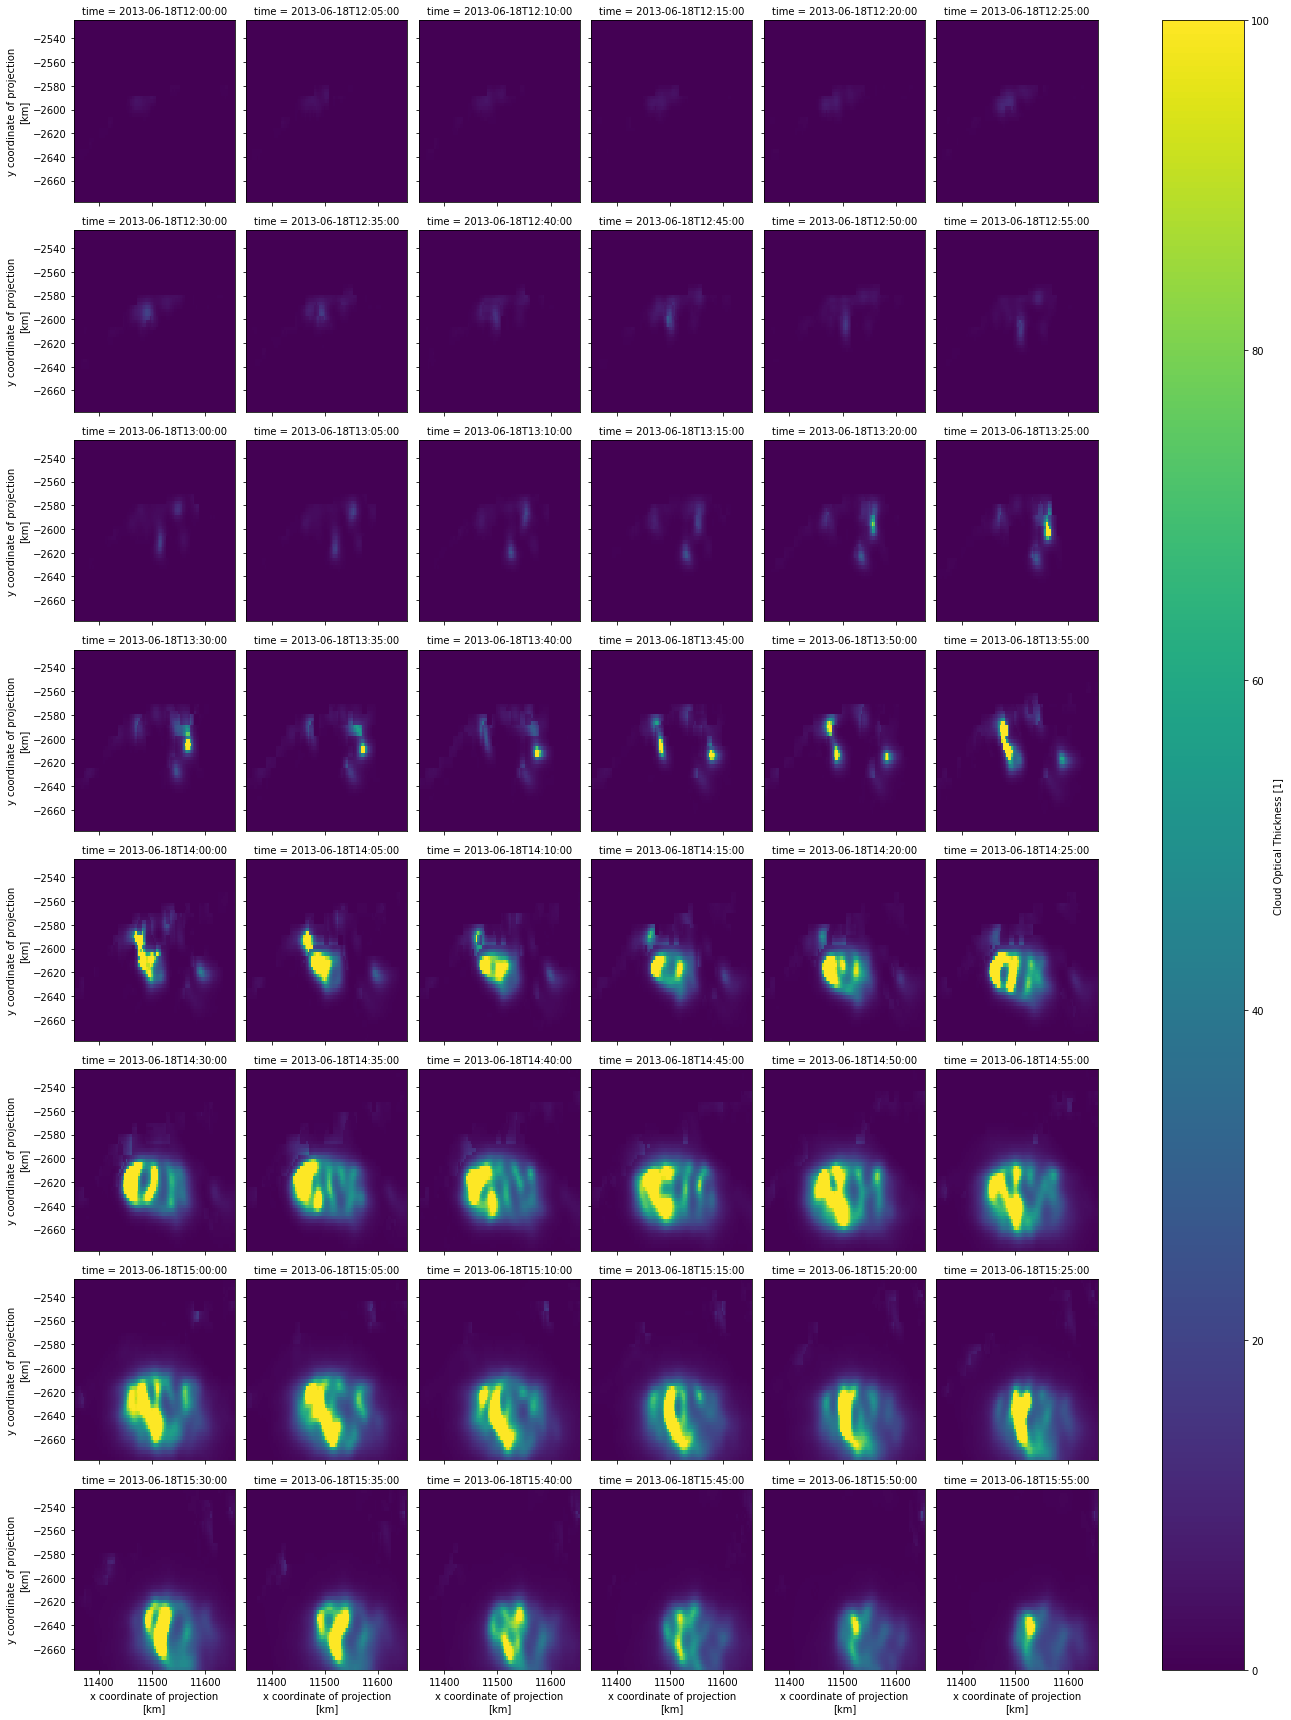

In [13]:
ds2.cot.plot(x='x',y='y',col='time',col_wrap=6)

In [6]:
print("lon min = {},\n lon max = {}".format(ds2.lon.data.min(),ds2.lon.data.max()))

lon min = 10.539999961853027,
 lon max = 12.09000015258789


In [7]:
print("lat min = {},\n lat max = {}".format(ds2.lat.data.min(),ds2.lat.data.max()))

lat min = 50.15999984741211,
 lat max = 51.07999801635742


Es gibt viele CPP-Satellitenprodukt. Anscheinend müssen wir die uns selbst ausschneiden. Dafür ermitteln wir uns zunächst mal die Startkoordinaten.

In [8]:
haci_data = pd.read_csv("/vols/satellite/home/lenk/data/HACI_bbox_data/haci_cases_2013.csv")

In [9]:
case = haci_data[(haci_data.date=='2013-06-18') & (haci_data.time=='12:55') & (haci_data.t1 - haci_data.t0>=5)]

In [10]:
case

,date,time,id,flags,t0,t1,l00,l01,c00,c01,l0,l1,c0,c1
99943,2013-06-18,12:55,1614,0,155,161,393,396,625,628,391,398,625,635


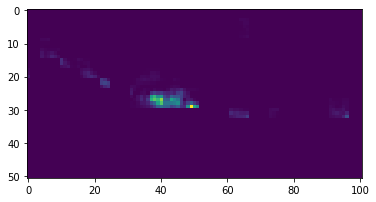

In [17]:
plt.imshow(ds1.cot.data[0])

In [22]:
print(ds1.cot.data[0].shape)

(51, 101)


Das scheint der gesuchte Fall zu sein.

In [13]:
r = radolan.Radolan()

In [14]:
print(r.lon[case.l0, case.c0][0])

11.362950763734535


In [15]:
print(r.lat[case.l0, case.c0][0])

50.490547044993754


Das passt zu dem Ausschnitt. Dann suchen wir uns als nächstes die zugehörigen MSG-Pixelkoordinaten.

In [18]:
slon,slat = mst.get_msg_lon_lat(region='eu')
hlon = mhu.make_hrv_upscaling(slon)
hlat = mhu.make_hrv_upscaling(slat)

/vols/satellite/home/lenk/anaconda3/envs/tracking/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


In [19]:
def get_index_kdtree(points, lat, lon):
    """
    Determine index of given points in the given coordinate arrays.
    
    Inputs:
        points: array-like, array([[lats],[lons]]), float
            points for which the indices are to be determined
        lat: array-like, float
            array of latitude coordinates 
        lon: array-like, float
            array of longitude coordinates
        
    Returns:
        indices: list with index sets of closest coordinate points to the given points    
    """
    
    from scipy.spatial import cKDTree
    import numpy as np
    
    # combine coordinate arrays into one stack
    combined_coordinate_arrays = np.dstack([lat.ravel(),lon.ravel()])[0]
    
    # transform points into a list
    points_list = list(points.transpose())
    
    # create cKDTree in which to look for the coordinates 
    tree = cKDTree(combined_coordinate_arrays)
    
    # query cKDTree
    dist, indices = tree.query(points_list)
    
    # re-transform coordinates to match starting coordinate array shapes
    results = []
    
    for idx in indices:
        results.append(np.unravel_index(idx,lon.shape))
        
    return results

In [20]:
points = np.array([[ds2.lat.data.min(),r.lat[case.l0,case.c0][0],ds2.lat.data.max()],
                   [ds2.lon.data.min(),r.lon[case.l0,case.c0][0],ds2.lon.data.max()]])

In [21]:
idx = get_index_kdtree(points,hlat,hlon)

In [62]:
idx

[(545, 1571), (527, 1625), (495, 1671)]

In [64]:
print("Zeilen: min = {}, max = {}\nSpalten: min = {}, max = {}".format(idx[0][0],idx[-1][0],idx[0][1],idx[-1][1]))

Zeilen: min = 545, max = 495
Spalten: min = 1571, max = 1671


Das ergibt für den Auschnitt {{idx[0][0] - idx[-1][0]}} px in Zeilenrichtung und {{idx[-1][1] - idx[0][1]}} px in Spaltenrichtung. Das passt ganz gut mit der Größe von Hartwigs Ausschnitt von {{ds1.cot.data[0].shape[0]}}&thinsp;px&thinsp;&times;&thinsp;{{ds1.cot.data[0].shape[1]}}&thinsp;px überein. Er rundet die Position des Ausgangspixels vielleicht anders. Vielleicht bekommen wir eine bessere Übereinstimmung, wenn wir einfach den Startpunkt nehmen und eine Box um diesen Punkt ausschneiden. Die Auschnittsgröße ist {{ds1.cot.data[0].shape[0]}}&thinsp;px&thinsp;&times;&thinsp;{{ds1.cot.data[0].shape[1]}}&thinsp;px. Also können wir den Ausschnitt folgendermaßen konstruieren:

In [29]:
rmin = idx[1][0] - ds1.cot.data[0].shape[0]//2
rmax = idx[1][0] + ds1.cot.data[0].shape[0]//2 + 1
print("rmin = {}, rmax = {}".format(rmin,rmax))

rmin = 502, rmax = 578


In [31]:
cmin = idx[1][1] - ds1.cot.data[0].shape[1]//2
cmax = idx[1][1] + ds1.cot.data[0].shape[1]//2 + 1
print("cmin = {}, cmax = {}".format(cmin,cmax))

cmin = 1575, cmax = 1676


Damit können wir uns die auf HRV-Auflösung interpolierten Satellitendaten laden.

In [116]:
test_file = "/vols/satellite/home/lenk/data/hres_data/calibrated/msg2-sevi-20130618T1200Z-hr-cal-vap-rss.de.c3.nc"

In [117]:
test_data = xr.open_dataset(test_file)

In [118]:
test_data

<xarray.Dataset>
Dimensions:  (x: 720, y: 1200)
Coordinates:
    lon      (x, y) float64 ...
    lat      (x, y) float64 ...
Dimensions without coordinates: x, y
Data variables:
    vis006   (x, y) float64 ...
    vis008   (x, y) float64 ...
    ir_016   (x, y) float64 ...
    ir_039   (x, y) float64 ...
    wv_062   (x, y) float64 ...
    wv_073   (x, y) float64 ...
    ir_087   (x, y) float64 ...
    ir_097   (x, y) float64 ...
    ir_108   (x, y) float64 ...
    ir_120   (x, y) float64 ...
    ir_134   (x, y) float64 ...
    z        (x, y) float64 ...
    cth      (x, y) float64 ...
    ctt      (x, y) uint8 ...
    ctp      (x, y) float64 ...
    ct       (x, y) float64 ...
    cma      (x, y) float64 ...
    hrv      (x, y) float64 ...
Attributes:
    title:               MSG, Radolam and NWCSAF v2016 products for 20130618T...
    institution:         Leibniz Institute for Tropospheric Research
    contact_person:      Stephan Lenk, lenk@tropos.de
    processing_time:     2019120

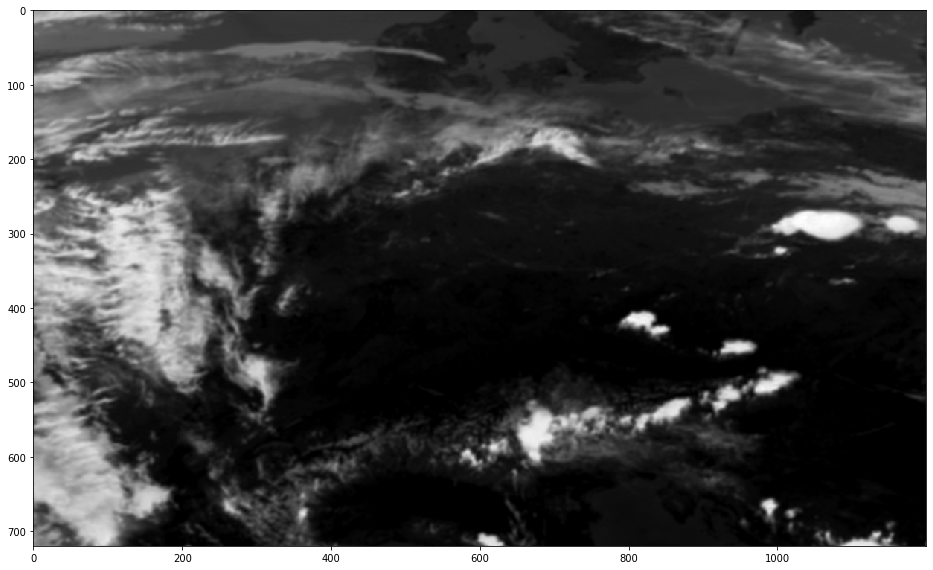

In [119]:
fig,ax = plt.subplots(1,1,figsize=(16,10))
ax.imshow(test_data.ir_108,vmin=210,vmax=300,cmap='gray_r')

In [41]:
idx = get_index_kdtree(points,test_data.lat.data,test_data.lon.data)

In [108]:
idx

[(365, 611), (347, 665), (315, 711)]

In [42]:
rmin = idx[1][0] - ds1.cot.data[0].shape[0]//2
rmax = idx[1][0] + ds1.cot.data[0].shape[0]//2 + 1
print("rmin = {}, rmax = {}".format(rmin,rmax))
cmin = idx[1][1] - ds1.cot.data[0].shape[1]//2
cmax = idx[1][1] + ds1.cot.data[0].shape[1]//2 + 1
print("cmin = {}, cmax = {}".format(cmin,cmax))

rmin = 322, rmax = 373
cmin = 615, cmax = 716


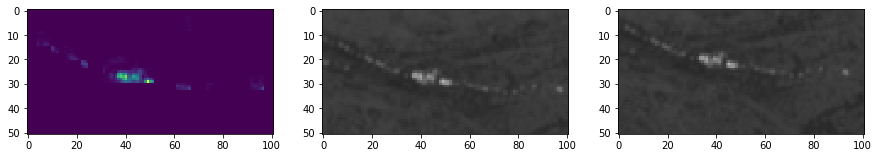

In [120]:
fig,ax = plt.subplots(1,3,figsize=(15,5))
ax[0].imshow(ds1.cot.data[0])
ax[1].imshow(test_data.hrv.data[idx[-1][0]:idx[0][0]+1,idx[0][1]:idx[-1][1]+1],vmin=0,vmax=0.8,cmap='gray')
ax[2].imshow(test_data.hrv.data[322:373,615:716],vmin=0,vmax=0.8,cmap='gray')

Der erste Ausschnitt scheint besser zu dem Ausschnitt mit den Mikrophysikdaten zu passen. Aber passen sie perfekt?

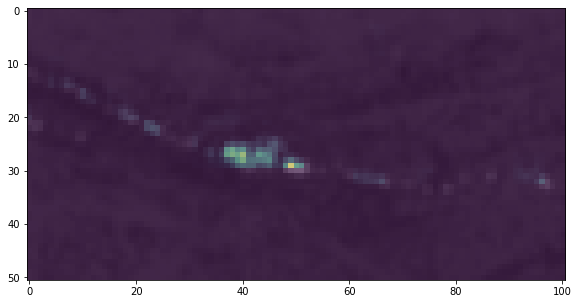

In [121]:
fig,ax = plt.subplots(1,1,figsize=(10,5))
ax.imshow(ds1.cot.data[0])
ax.imshow(test_data.hrv.data[idx[-1][0]:idx[0][0]+1,idx[0][1]:idx[-1][1]+1],vmin=0,vmax=0.8,cmap='gray',alpha=0.6)

OK, das passt sehr gut. Dann können wir uns ein paar benötigte Daten ausschneiden. Wir benötigen folgendes:

1. Kanäle für das NC-Komposit (VIS&thinsp;0,6&thinsp;mm, VIS&thinsp;0,8&thinsp;µm, NIR&thinsp;1,6&thinsp;µm)
2. IR&thinsp;10,8&thinsp;µm
3. RADOLAN RX

In [122]:
fields = test_data.data_vars.keys()
rmin = idx[-1][0]
rmax = idx[0][0]+1
cmin = idx[0][1]
cmax = idx[-1][1]+1

In [185]:
import numpy as np
import scipy.ndimage as ndi
import numpy as np
import skimage

from analysis_tools import parallax as px

import l15_msevi.msevi_config as msvc

import sys
sys.path.append("/vols/talos/home/stephan/utils/")
import msg_coord_conv as mcc

from analysis_tools import grid_and_interpolation as gi

def parallax_correct_satellite_field(field,source_lon,source_lat,
                                     cloud_top_height,sat_res_id,sat_region_id,\
                                     sat_scan_service_id,gauss_sig):
    """
    Do a parallax correction on the native MSG grid.
    
    Inputs:
    -------
    field: numpy array, 2d
        field to perform parallax correction for
    source_lon: numpy array, 2d, same shape as field
        longitude coordinates of the field pixels in degress
    source_lat: numpy array, 2d, same shape as field
        latitude coordinates of the field pixels in degrees
    cloud_top_height: numpy array, 2d same shape as field
        cloud top height of the field's pixels in meters 
    sat_res_id: string, 'std' or 'hrv'
        identifier for the satellite resolution
    sat_region_id: string, e.g. 'eu'
        identifier for the used satellite region
    sat_scan_service_id: string, 'rss' or 'pts'
        identifier for the satellite scan intervall
    gauss_sig: int or float
        value parameter sigma of the 2d Gauß smoothing
        
    Returns:
    --------
    field_warped: numpy array, 2d
        field warped to the new coordinates
    """
    
    
    
    # get satellite longitude
    _sat_longitudes = {'rss': 9.5,
                       'pzs': 0.0}
    
    sat_lon = _sat_longitudes[sat_scan_service_id]
    
    # smooth the cloud top height to achieve smoother parallax transformation
    cth_smooth =  ndi.maximum_filter(cloud_top_height, size = 3*gauss_sig)
    cth_smooth =  ndi.gaussian_filter(cth_smooth, gauss_sig)

    # do the parallax on coordiantes vector
    plon, plat = px.parallax_correction(source_lon, source_lat, cth_smooth, satlon = sat_lon)
    
    # convert the new geodetic coordinates into grid ones
    picol,pirow = mcc.ll2cl(plon,plat,sat_res_id,sat_scan_service_id,'oben')
    
    # correct the grid coordiantes by the region offsets
    region_id = "{}-{}".format(sat_region_id,sat_scan_service_id)
    
    col_offset = msvc._predefined_regions[region_id][1][0]
    row_offset = msvc._predefined_regions[region_id][0][0]

    # take care of resolution differences
    if sat_res_id == 'hrv':
        factor = 3.
    else:
        factor = 1.
   
    pirow -= factor * row_offset
    picol -= factor * col_offset    
    
    # prepare image warping
    irow, icol = gi.make_index_set(*source_lon.shape)

    dirow = pirow - irow
    dicol = picol - icol

    ind =  np.array([irow - dirow, icol - dicol])

    # image warping needs normalised fields
    fmin = field.min()
    fmax = field.max()
    df = fmax - fmin

    if df > 0:
        fnorm = (field - fmin) / df
    else:
        fnorm = field - fmin

    # warp image
    fn_warp = skimage.transform.warp(fnorm, ind, order = 3, mode = 'edge' )

    f_warp = df * fn_warp + fmin
    
    return f_warp

def parallax_correction(lon, lat, height, satlon = 9.5):

    '''
    Calculates parallax-corrected longitude and latitude values. Adapted 
    from NWCSAF.

    INPUT
    =====
    lon: longitude
    lat: latitude
    height: cloud-top height (m)
    datlon: OPTIONAL, longitude position of satellite 

    OUTPUT
    ======
    plon: corrected longitude
    plat: corrected latitude
    '''


    # earth ellipsoid
    POLE_EARTH_RADIUS = 6356.58
    EQUATOR_EARTH_RADIUS = 6378.17
    aorbit=42165390

    aplr = POLE_EARTH_RADIUS * 1000
    aeqr = EQUATOR_EARTH_RADIUS * 1000
    aratio = aeqr / aplr

    # Convert angles from degrees to radians and height from ft to m
    # --------------------------------------------------------------
    lat = np.deg2rad(lat)
    lon = np.deg2rad(lon)

    # Get x-y-z coordinates for satellite */
    # slat1 is the geometric latitude for geodetic lat satlat
    # ------------------------------------------------------- */
    satlon = np.deg2rad(satlon)
    satlat = 0
    slat1 = np.arctan( np.tan(satlat)*(aratio*aratio))
    
    xs = aorbit * np.cos(slat1) * np.sin(satlon)
    ys = aorbit * np.sin(slat1)
    zs = aorbit * np.cos(slat1) * np.cos(satlon)

    # Get x-y-z coordinates for surface point */
    # --------------------------------------- */
    lat1 = np.arctan( np.tan(lat) * (aratio*aratio) )
    
    ri = aeqr/np.sqrt((np.cos(lat1) * np.cos(lat1))\
                          +(aratio*aratio) * (np.sin(lat1)*np.sin(lat1)))

    xi = ri * np.cos(lat1) * np.sin(lon)
    yi = ri * np.sin(lat1)
    zi = ri * np.cos(lat1) * np.cos(lon)

    # b is the new aratio */
    # ------------------- */
    b = (((aeqr + height) / (aplr + height)) * ((aeqr + height) / (aplr + height)))

    xsmxi = xs - xi
    ysmyi = ys - yi
    zsmzi = zs - zi

    e = (xsmxi*xsmxi) + b*(ysmyi*ysmyi) + (zsmzi*zsmzi)
    ef = 2*(xi*xsmxi+b*yi*ysmyi+zi*zsmzi)
    eg = (xi*xi)+(zi*zi)+b*(yi*yi)-((aeqr+height)*(aeqr+height))
    a = (np.sqrt((ef*ef)-4*e*eg) - ef)/2/e

    # Corrected xyz */
    # ------------- */
    xc = xi + a * xsmxi
    yc = yi + a * ysmyi
    zc = zi + a * zsmzi

    # Convert back to lat/lon */
    # ----------------------- */
    aux = np.arctan(yc / np.sqrt((xc*xc)+(zc*zc)))

    lat_new  = np.arctan( np.tan(aux) / (aratio*aratio))
    lon_new = np.arctan2(xc,zc)

    return np.rad2deg(lon_new), np.rad2deg(lat_new)

In [123]:
fields

KeysView(Data variables:
    vis006   (x, y) float64 ...
    vis008   (x, y) float64 ...
    ir_016   (x, y) float64 ...
    ir_039   (x, y) float64 ...
    wv_062   (x, y) float64 ...
    wv_073   (x, y) float64 ...
    ir_087   (x, y) float64 ...
    ir_097   (x, y) float64 ...
    ir_108   (x, y) float64 241.9 242.6 243.1 243.1 ... 298.4 297.2 293.7 287.5
    ir_120   (x, y) float64 ...
    ir_134   (x, y) float64 ...
    z        (x, y) float64 ...
    cth      (x, y) float64 ...
    ctt      (x, y) uint8 ...
    ctp      (x, y) float64 ...
    ct       (x, y) float64 ...
    cma      (x, y) float64 ...
    hrv      (x, y) float64 0.44 0.4136 0.3886 0.3886 ... 0.1692 0.1692 0.1612)

In [124]:
times = ds1.time.data

In [125]:
times

array(['2013-06-18T12:00:00.000000000', '2013-06-18T12:05:00.000000000',
       '2013-06-18T12:10:00.000000000', '2013-06-18T12:15:00.000000000',
       '2013-06-18T12:20:00.000000000', '2013-06-18T12:25:00.000000000',
       '2013-06-18T12:30:00.000000000', '2013-06-18T12:35:00.000000000',
       '2013-06-18T12:40:00.000000000', '2013-06-18T12:45:00.000000000',
       '2013-06-18T12:50:00.000000000', '2013-06-18T12:55:00.000000000',
       '2013-06-18T13:00:00.000000000', '2013-06-18T13:05:00.000000000',
       '2013-06-18T13:10:00.000000000', '2013-06-18T13:15:00.000000000',
       '2013-06-18T13:20:00.000000000', '2013-06-18T13:25:00.000000000',
       '2013-06-18T13:30:00.000000000', '2013-06-18T13:35:00.000000000',
       '2013-06-18T13:40:00.000000000', '2013-06-18T13:45:00.000000000',
       '2013-06-18T13:50:00.000000000', '2013-06-18T13:55:00.000000000',
       '2013-06-18T14:00:00.000000000', '2013-06-18T14:05:00.000000000',
       '2013-06-18T14:10:00.000000000', '2013-06-18

In [127]:
sat_data_path = "/vols/satellite/home/lenk/data/hres_data/calibrated/"

In [183]:
cutouts = {f:[] for f in fields}

for t in times:
    pd.Timestamp(t)
    with xr.open_dataset("{}/msg2-sevi-{}-hr-cal-vap-rss.de.c3.nc".format(sat_data_path,
                                                                          pd.Timestamp(t).strftime("%Y%m%dT%H%MZ"))) as data:
        for f in fields:
            field_data = data[f].data
            
            data_corrected = parallax_correct_msg(field_data,
                                                  data.lon.data,
                                                  data.lat.data,
                                                  data.cth.data,'hrv','meu','rss',1)
            
            cutouts[f].append(data_corrected[rmin:rmax,cmin:cmax])

MemoryError: 

In [129]:
cutouts

{'vis006': [array([[0.0937, 0.0925, 0.0937, ..., 0.0997, 0.0997, 0.102 ],
         [0.0937, 0.0914, 0.0914, ..., 0.0974, 0.0986, 0.0997],
         [0.0937, 0.0914, 0.0902, ..., 0.0951, 0.0963, 0.0986],
         ...,
         [0.0816, 0.0782, 0.0771, ..., 0.0728, 0.0739, 0.0751],
         [0.0805, 0.0771, 0.0748, ..., 0.0762, 0.0762, 0.0773],
         [0.0827, 0.0771, 0.0737, ..., 0.0796, 0.0796, 0.0796]]),
  array([[0.0917, 0.0917, 0.0928, ..., 0.0989, 0.1   , 0.1024],
         [0.0928, 0.0916, 0.0916, ..., 0.0977, 0.0989, 0.1012],
         [0.0928, 0.0916, 0.0905, ..., 0.0954, 0.0977, 0.1   ],
         ...,
         [0.083 , 0.0807, 0.0784, ..., 0.0764, 0.0764, 0.0765],
         [0.083 , 0.0796, 0.0773, ..., 0.0776, 0.0776, 0.0776],
         [0.0852, 0.0796, 0.0761, ..., 0.0787, 0.0787, 0.0787]]),
  array([[0.0931, 0.0931, 0.0942, ..., 0.0992, 0.1004, 0.1027],
         [0.0919, 0.0919, 0.0931, ..., 0.0969, 0.0992, 0.1015],
         [0.0919, 0.0908, 0.0908, ..., 0.0946, 0.0969, 0.0992]

In [130]:
def normalise2range(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def array_to_256(array):
    return (array*255.999).astype("uint8")

def day_natural_composite(vis006_data,vis008_data,nir016_data,factor=1,gamma=1):
    blue = array_to_256(np.clip(vis006_data/factor,0,1)**(1./gamma))
    green = array_to_256(np.clip(vis008_data/factor,0,1)**(1./gamma))
    red = array_to_256(np.clip(nir016_data/factor,0,1)**(1./gamma))
    
    return np.dstack([red,green,blue]).astype("uint8")

In [131]:
nc_composites = []

for i, vis006 in enumerate(cutouts['vis006']):
    nc_composites.append(day_natural_composite(vis006,
                                               cutouts['vis008'][i],
                                               cutouts['ir_016'][i]))

In [132]:
from plotting_tools.colormaps import enhanced_colormap
emap = enhanced_colormap(vmin=210,vmed=240,vmax=300)
from plotting_tools.colormaps import radar_cmap as rc

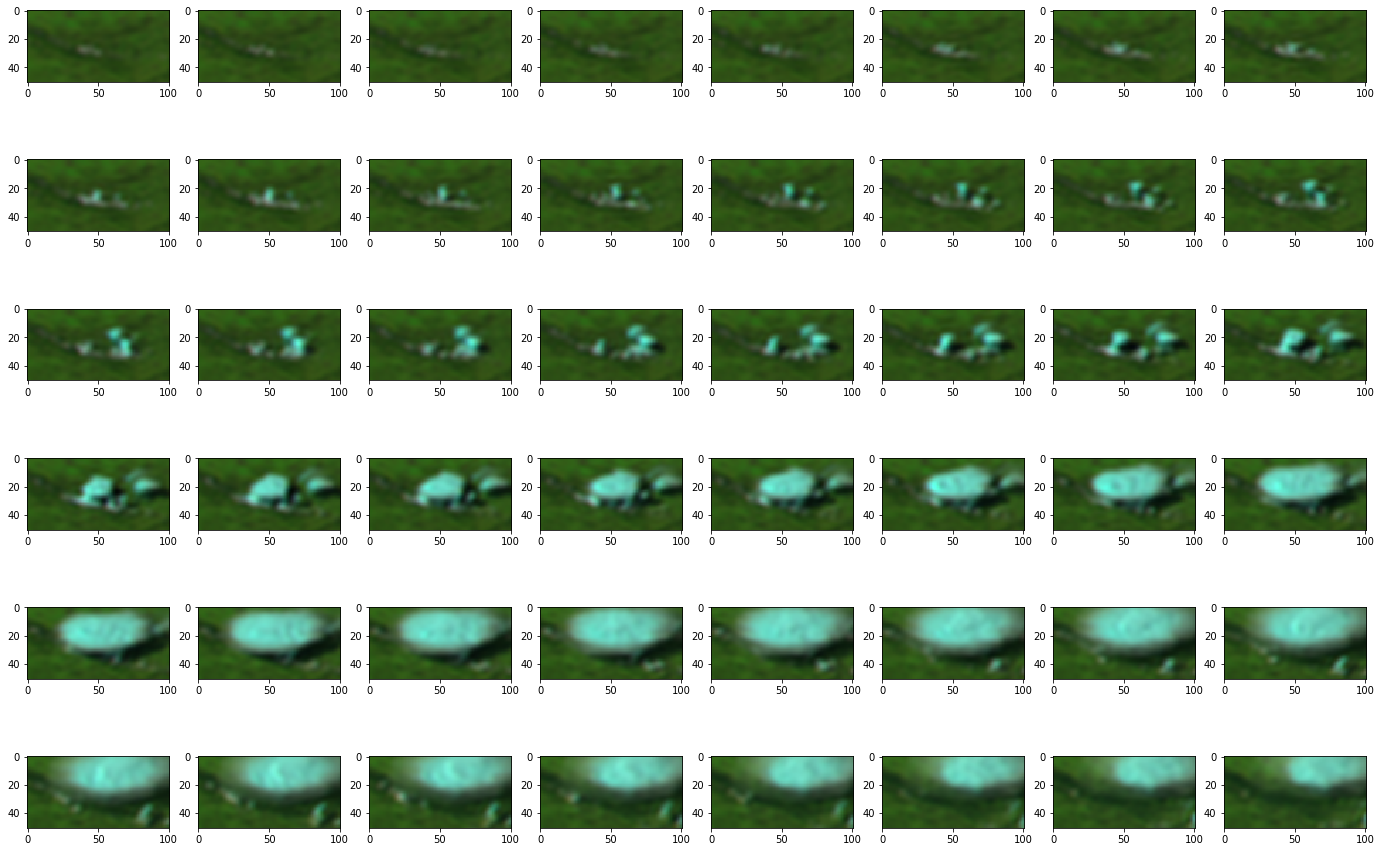

In [133]:
fig, ax = plt.subplots(6,8,figsize=(24,16))
axs=ax.ravel()

for i, ncc in enumerate(nc_composites):
    axs[i].imshow(ncc)

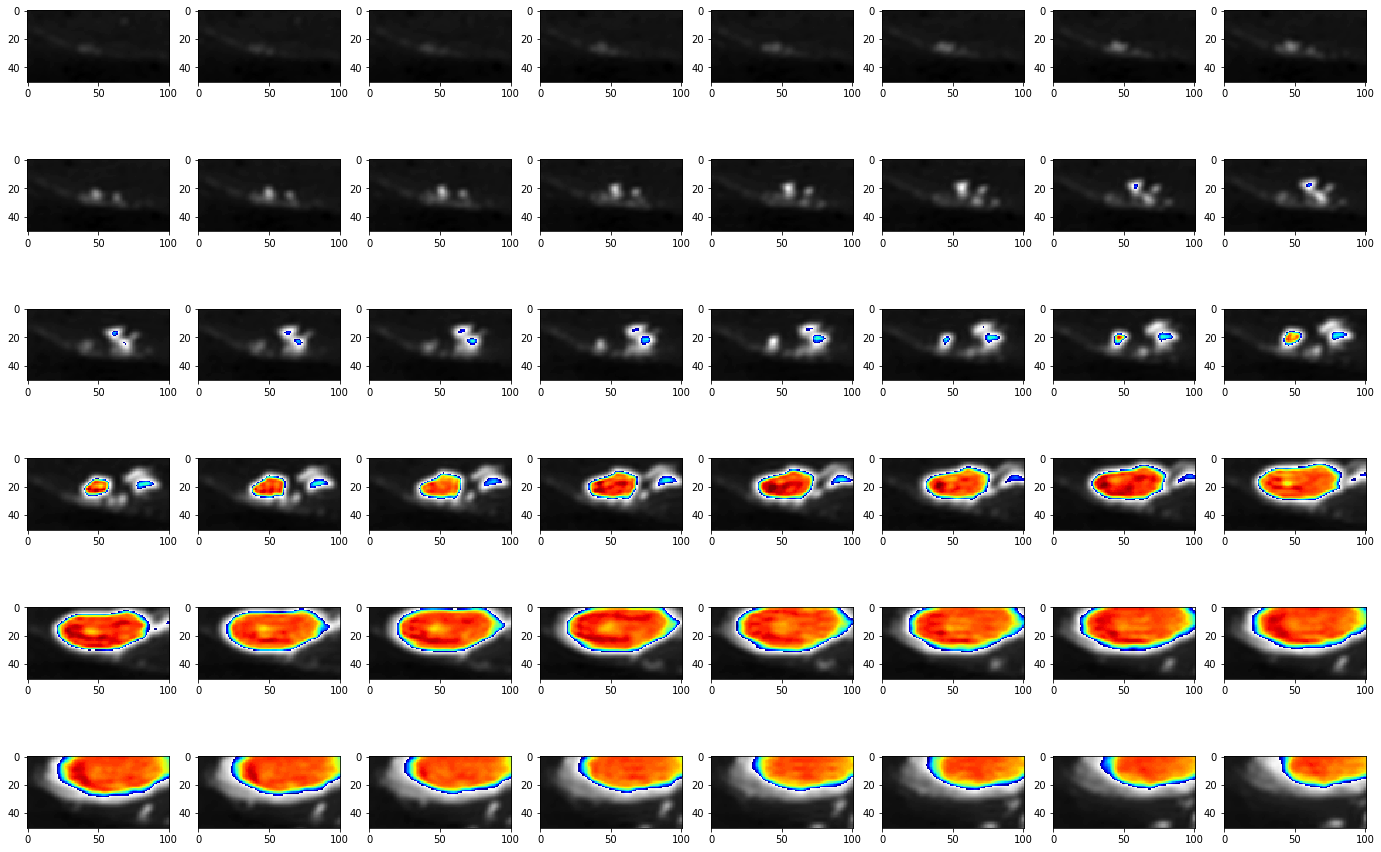

In [134]:
fig, ax = plt.subplots(6,8,figsize=(24,16))
axs=ax.ravel()

for i, ir in enumerate(cutouts['ir_108']):
    axs[i].imshow(ir,vmin=210,vmax=300,cmap=emap)

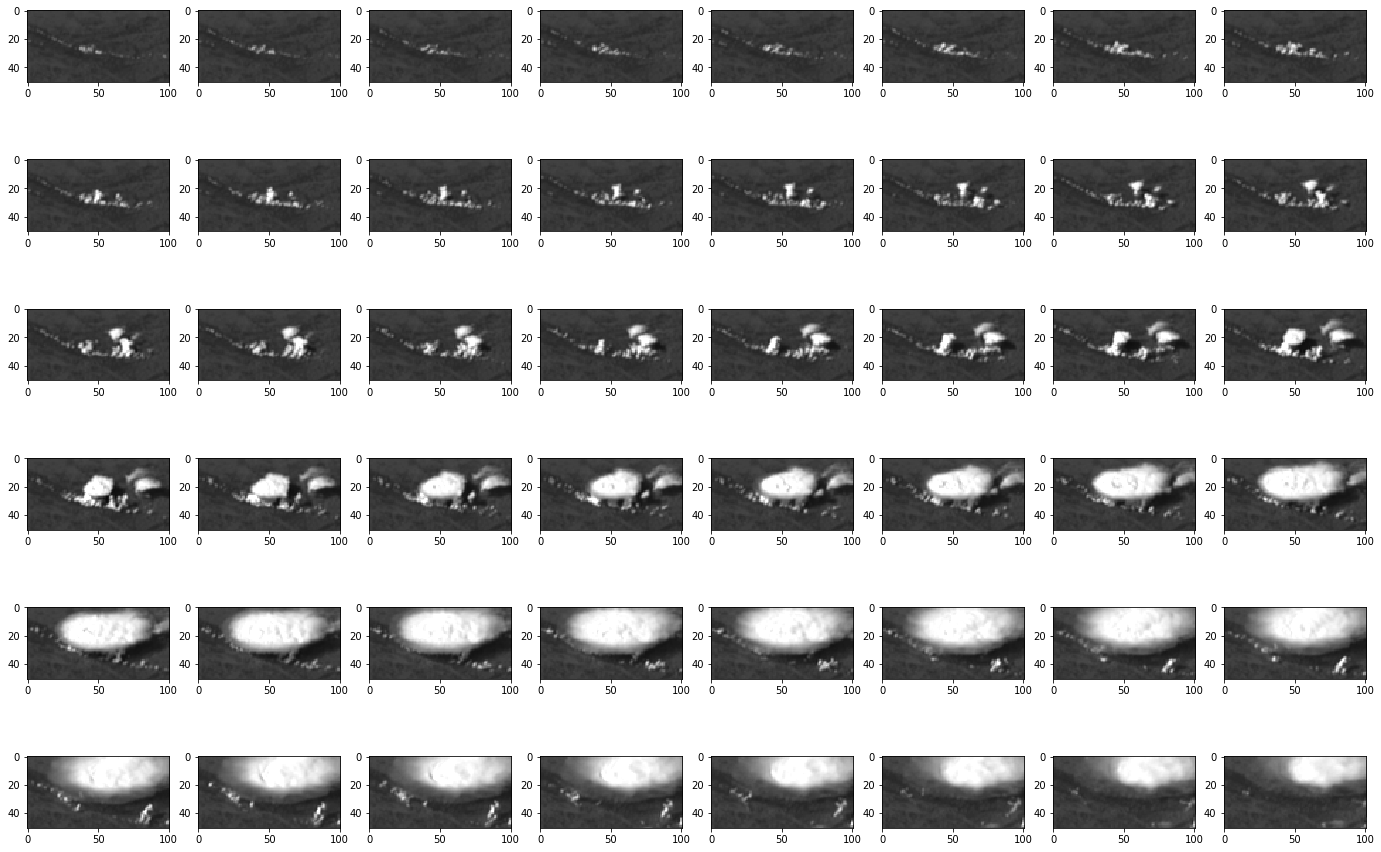

In [136]:
fig, ax = plt.subplots(6,8,figsize=(24,16))
axs=ax.ravel()

for i, h in enumerate(cutouts['hrv']):
    axs[i].imshow(h,vmin=0,vmax=0.8,cmap='gray')

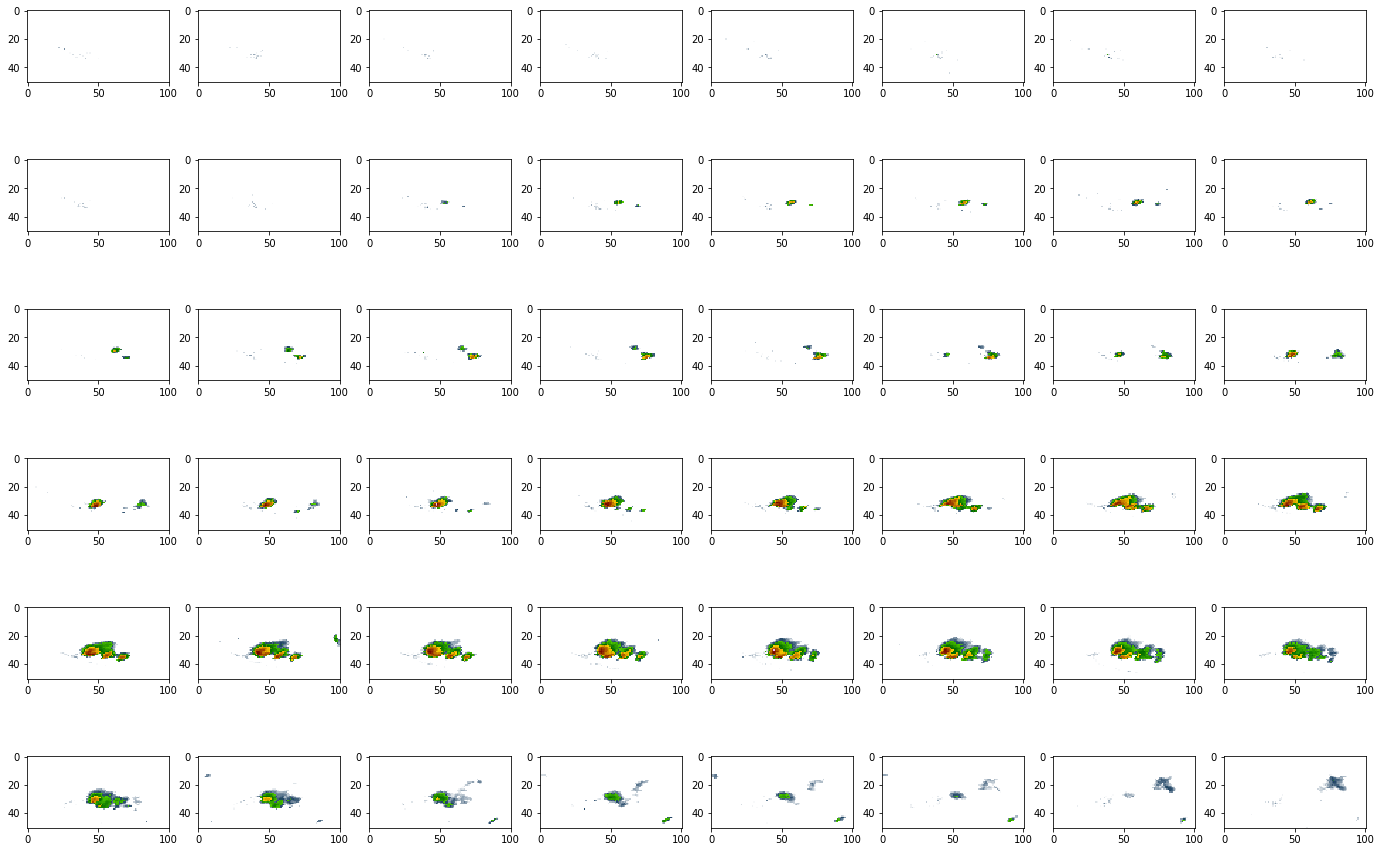

In [135]:
fig, ax = plt.subplots(6,8,figsize=(24,16))
axs=ax.ravel()

for i, z in enumerate(cutouts['z']):
    axs[i].imshow(z,vmin=5,vmax=70,cmap=rc())

Dann erzeugen wir mal eine Darstellung von NC, IR&thinsp;10,8&thinsp;µm-Kanal und RADOLAN RX. Dafür benötigen wir aber eine Parallxenkorrektur. Die Parallaxenkorrektur sollte am besten vor dem Ausschneiden erfolgen, aber dafür fehlen wahrscheinlich die Wolkenhöhedaten.

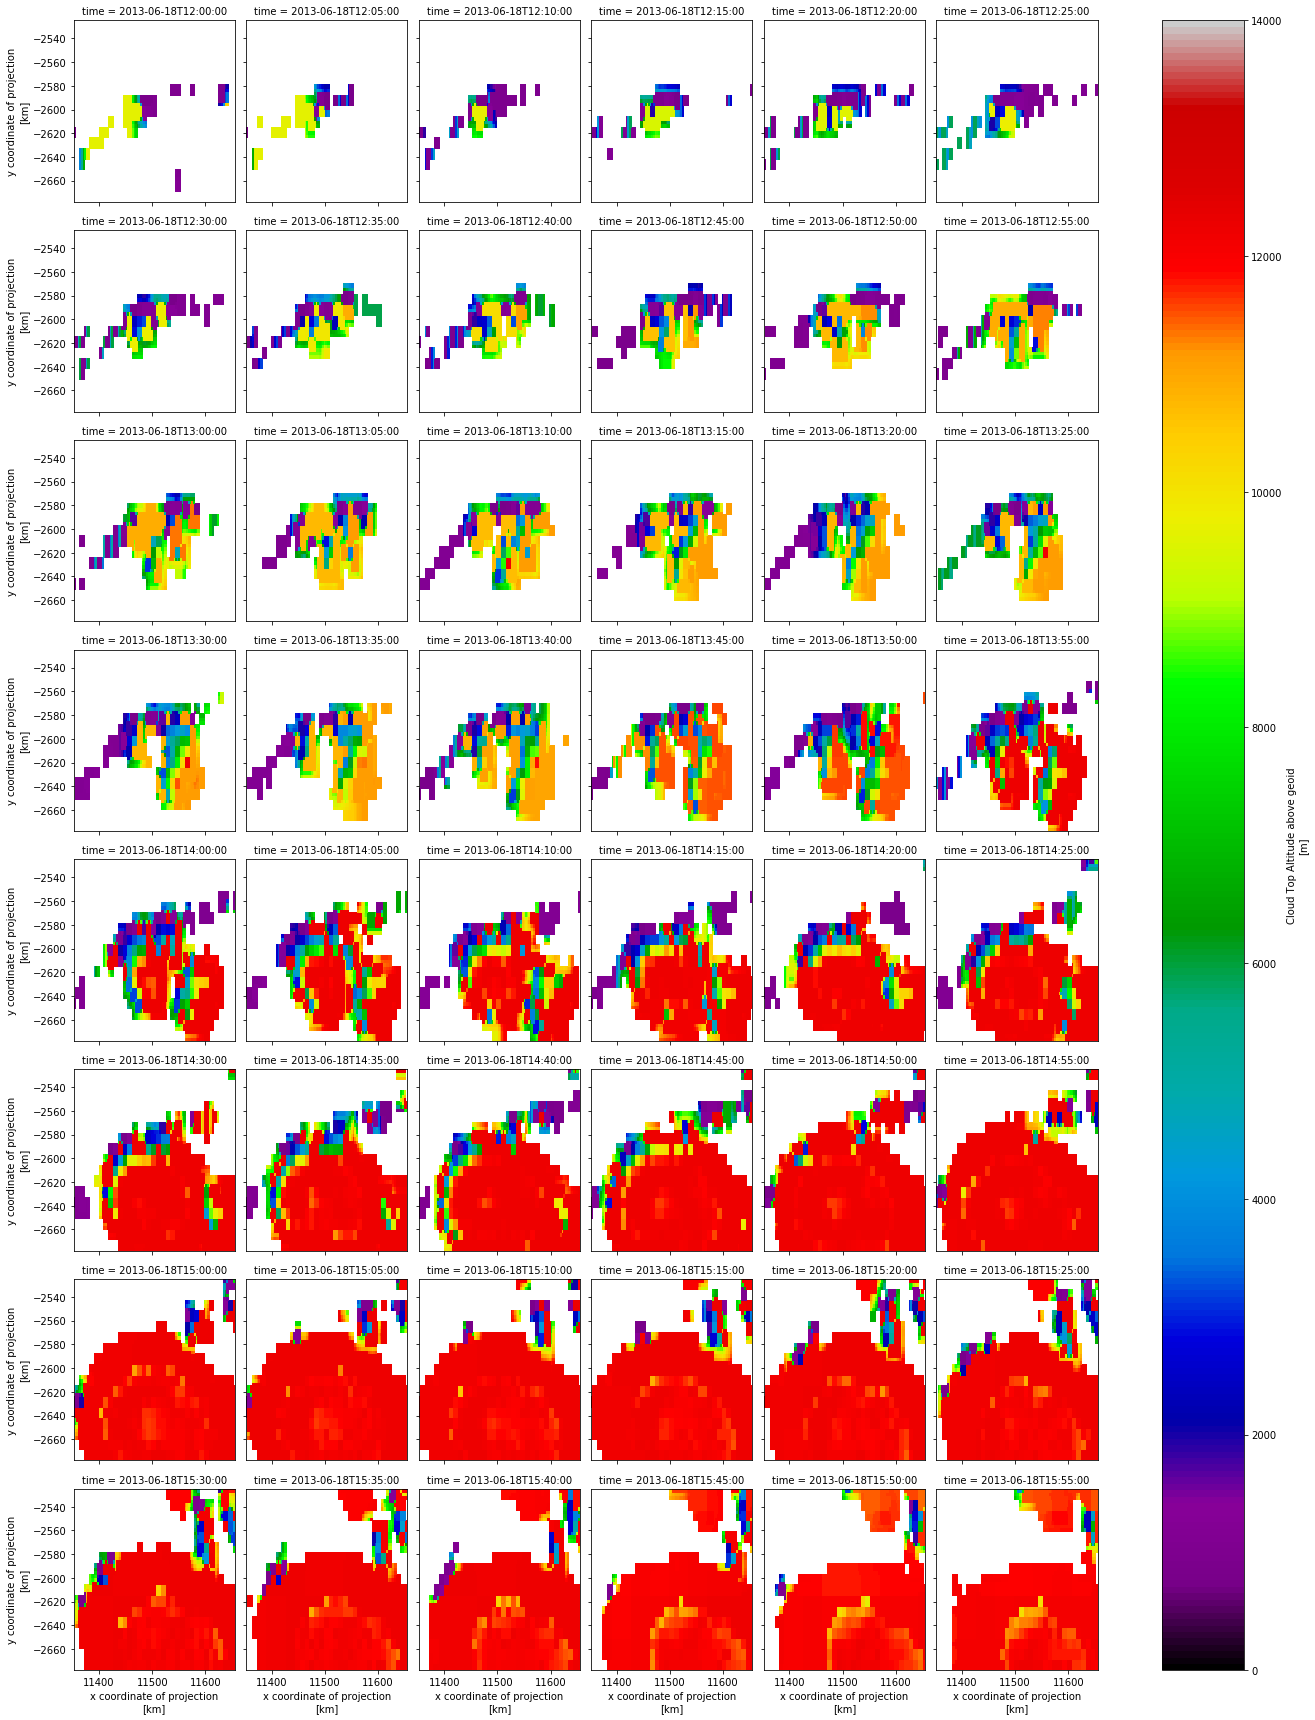

In [144]:
ds1.cth.plot(x='x',y='y',col='time',col_wrap=6,cmap='nipy_spectral',vmin=0,vmax=14000)

In [141]:
ds1.cth

<xarray.DataArray 'cth' (time: 48, y: 51, x: 101)>
array([[[   nan,    nan, ...,    nan,    nan],
        [   nan,    nan, ...,    nan,    nan],
        ...,
        [   nan,    nan, ...,    nan,    nan],
        [   nan,    nan, ...,    nan,    nan]],

       [[   nan,    nan, ...,    nan,    nan],
        [   nan,    nan, ...,    nan,    nan],
        ...,
        [   nan,    nan, ...,    nan,    nan],
        [   nan,    nan, ...,    nan,    nan]],

       ...,

       [[   nan,    nan, ..., 11380., 11813.],
        [   nan,    nan, ..., 11380., 11813.],
        ...,
        [   nan,    nan, ..., 11427., 11427.],
        [   nan,    nan, ..., 11427., 11427.]],

       [[   nan,    nan, ..., 11984., 11937.],
        [   nan,    nan, ..., 11984., 11937.],
        ...,
        [   nan,    nan, ..., 11514., 11514.],
        [   nan,    nan, ..., 11514., 11514.]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2013-06-18T12:00:00 ... 2013-06-18T15:55:00
  * x        (x) 

In [2]:
import numpy as np
import scipy.ndimage as ndi
import numpy as np
import skimage

from analysis_tools import parallax as px

import l15_msevi.msevi_config as msvc

import sys
sys.path.append("/vols/talos/home/stephan/utils/")
import msg_coord_conv as mcc

from analysis_tools import grid_and_interpolation as gi

def parallax_correct_satellite_field(field,source_lon,source_lat,
                                     cloud_top_height,sat_res_id,sat_region_id,\
                                     sat_scan_service_id,gauss_sig):
    """
    Do a parallax correction on the native MSG grid.
    
    Inputs:
    -------
    field: numpy array, 2d
        field to perform parallax correction for
    source_lon: numpy array, 2d, same shape as field
        longitude coordinates of the field pixels in degress
    source_lat: numpy array, 2d, same shape as field
        latitude coordinates of the field pixels in degrees
    cloud_top_height: numpy array, 2d same shape as field
        cloud top height of the field's pixels in meters 
    sat_res_id: string, 'std' or 'hrv'
        identifier for the satellite resolution
    sat_region_id: string, e.g. 'eu'
        identifier for the used satellite region
    sat_scan_service_id: string, 'rss' or 'pts'
        identifier for the satellite scan intervall
    gauss_sig: int or float
        value parameter sigma of the 2d Gauß smoothing
        
    Returns:
    --------
    field_warped: numpy array, 2d
        field warped to the new coordinates
    """
    
    
    
    # get satellite longitude
    _sat_longitudes = {'rss': 9.5,
                       'pzs': 0.0}
    
    sat_lon = _sat_longitudes[sat_scan_service_id]
    
    # smooth the cloud top height to achieve smoother parallax transformation
    cth_smooth =  ndi.maximum_filter(cloud_top_height, size = 3*gauss_sig)
    cth_smooth =  ndi.gaussian_filter(cth_smooth, gauss_sig)

    # do the parallax on coordiantes vector
    plon, plat = px.parallax_correction(source_lon, source_lat, cth_smooth, satlon = sat_lon)
    
    # convert the new geodetic coordinates into grid ones
    picol,pirow = mcc.ll2cl(plon,plat,sat_res_id,sat_scan_service_id,'oben')
    
    # correct the grid coordiantes by the region offsets
    region_id = "{}-{}".format(sat_region_id,sat_scan_service_id)
    
    col_offset = msvc._predefined_regions[region_id][1][0]
    row_offset = msvc._predefined_regions[region_id][0][0]

    # take care of resolution differences
    if sat_res_id == 'hrv':
        factor = 3.
    else:
        factor = 1.
   
    pirow -= factor * row_offset
    picol -= factor * col_offset    
    
    # prepare image warping
    irow, icol = gi.make_index_set(*source_lon.shape)

    dirow = pirow - irow
    dicol = picol - icol

    ind =  np.array([irow - dirow, icol - dicol])

    # image warping needs normalised fields
    fmin = field.min()
    fmax = field.max()
    df = fmax - fmin

    if df > 0:
        fnorm = (field - fmin) / df
    else:
        fnorm = field - fmin

    # warp image
    fn_warp = skimage.transform.warp(fnorm, ind, order = 3, mode = 'edge' )

    f_warp = df * fn_warp + fmin
    
    return f_warp

def parallax_correction(lon, lat, height, satlon = 9.5):

    '''
    Calculates parallax-corrected longitude and latitude values. Adapted 
    from NWCSAF.

    INPUT
    =====
    lon: longitude
    lat: latitude
    height: cloud-top height (m)
    datlon: OPTIONAL, longitude position of satellite 

    OUTPUT
    ======
    plon: corrected longitude
    plat: corrected latitude
    '''


    # earth ellipsoid
    POLE_EARTH_RADIUS = 6356.58
    EQUATOR_EARTH_RADIUS = 6378.17
    aorbit=42165390

    aplr = POLE_EARTH_RADIUS * 1000
    aeqr = EQUATOR_EARTH_RADIUS * 1000
    aratio = aeqr / aplr

    # Convert angles from degrees to radians and height from ft to m
    # --------------------------------------------------------------
    lat = np.deg2rad(lat)
    lon = np.deg2rad(lon)

    # Get x-y-z coordinates for satellite */
    # slat1 is the geometric latitude for geodetic lat satlat
    # ------------------------------------------------------- */
    satlon = np.deg2rad(satlon)
    satlat = 0
    slat1 = np.arctan( np.tan(satlat)*(aratio*aratio))
    
    xs = aorbit * np.cos(slat1) * np.sin(satlon)
    ys = aorbit * np.sin(slat1)
    zs = aorbit * np.cos(slat1) * np.cos(satlon)

    # Get x-y-z coordinates for surface point */
    # --------------------------------------- */
    lat1 = np.arctan( np.tan(lat) * (aratio*aratio) )
    
    ri = aeqr/np.sqrt((np.cos(lat1) * np.cos(lat1))\
                          +(aratio*aratio) * (np.sin(lat1)*np.sin(lat1)))

    xi = ri * np.cos(lat1) * np.sin(lon)
    yi = ri * np.sin(lat1)
    zi = ri * np.cos(lat1) * np.cos(lon)

    # b is the new aratio */
    # ------------------- */
    b = (((aeqr + height) / (aplr + height)) * ((aeqr + height) / (aplr + height)))

    xsmxi = xs - xi
    ysmyi = ys - yi
    zsmzi = zs - zi

    e = (xsmxi*xsmxi) + b*(ysmyi*ysmyi) + (zsmzi*zsmzi)
    ef = 2*(xi*xsmxi+b*yi*ysmyi+zi*zsmzi)
    eg = (xi*xi)+(zi*zi)+b*(yi*yi)-((aeqr+height)*(aeqr+height))
    a = (np.sqrt((ef*ef)-4*e*eg) - ef)/2/e

    # Corrected xyz */
    # ------------- */
    xc = xi + a * xsmxi
    yc = yi + a * ysmyi
    zc = zi + a * zsmzi

    # Convert back to lat/lon */
    # ----------------------- */
    aux = np.arctan(yc / np.sqrt((xc*xc)+(zc*zc)))

    lat_new  = np.arctan( np.tan(aux) / (aratio*aratio))
    lon_new = np.arctan2(xc,zc)

    return np.rad2deg(lon_new), np.rad2deg(lat_new)

In [3]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

import MSGtools as mst
from analysis_tools import grid_and_interpolation as gi
from analysis_tools import make_hrv_upscaling as mhu
from io_tools import radolan

data_path = "/vols/satellite/home/hartwig/ci_case_hrv"

import scipy.ndimage as ndi
import skimage
import l15_msevi.msevi_config as msvc

import sys
sys.path.append("/vols/talos/home/stephan/utils/")
import msg_coord_conv as mcc


def parallax_correct_satellite_field(field,source_lon,source_lat,
                                     cloud_top_height,sat_res_id,sat_region_id,\
                                     sat_scan_service_id,gauss_sig):
    """
    Do a parallax correction on the native MSG grid.
    
    Inputs:
    -------
    field: numpy array, 2d
        field to perform parallax correction for
    source_lon: numpy array, 2d, same shape as field
        longitude coordinates of the field pixels in degress
    source_lat: numpy array, 2d, same shape as field
        latitude coordinates of the field pixels in degrees
    cloud_top_height: numpy array, 2d same shape as field
        cloud top height of the field's pixels in meters 
    sat_res_id: string, 'std' or 'hrv'
        identifier for the satellite resolution
    sat_region_id: string, e.g. 'eu'
        identifier for the used satellite region
    sat_scan_service_id: string, 'rss' or 'pts'
        identifier for the satellite scan intervall
    gauss_sig: int or float
        value parameter sigma of the 2d Gauß smoothing
        
    Returns:
    --------
    field_warped: numpy array, 2d
        field warped to the new coordinates
    """
    
    
    
    # get satellite longitude
    _sat_longitudes = {'rss': 9.5,
                       'pzs': 0.0}
    
    sat_lon = _sat_longitudes[sat_scan_service_id]
    
    # smooth the cloud top height to achieve smoother parallax transformation
    cth_smooth =  ndi.maximum_filter(cloud_top_height, size = 3*gauss_sig)
    cth_smooth =  ndi.gaussian_filter(cth_smooth, gauss_sig)
    cth_smooth[cloud_top_height==0] = 0

    # do the parallax on coordiantes vector
    plon, plat = parallax_correction(source_lon, source_lat, cth_smooth, satlon = sat_lon)
    
    # convert the new geodetic coordinates into grid ones
    picol,pirow = mcc.ll2cl(plon,plat,sat_res_id,sat_scan_service_id,'oben')
    
    # correct the grid coordiantes by the region offsets
    region_id = "{}-{}".format(sat_region_id,sat_scan_service_id)
    
    col_offset = msvc._predefined_regions[region_id][1][0]
    row_offset = msvc._predefined_regions[region_id][0][0]

    # take care of resolution differences
    if sat_res_id == 'hrv':
        factor = 3.
    else:
        factor = 1.
   
    pirow -= factor * row_offset
    picol -= factor * col_offset    
    
    # prepare image warping
    irow, icol = gi.make_index_set(*source_lon.shape)

    dirow = pirow - irow
    dicol = picol - icol

    ind =  np.array([irow - dirow, icol - dicol])

    # image warping needs normalised fields
    fmin = field.min()
    fmax = field.max()
    df = fmax - fmin

    if df > 0:
        fnorm = (field - fmin) / df
    else:
        fnorm = field - fmin

    # warp image
    fn_warp = skimage.transform.warp(fnorm, ind, order = 3, mode = 'edge' )

    f_warp = df * fn_warp + fmin
    
    return f_warp

def parallax_correction(lon, lat, height, satlon = 9.5):

    '''
    Calculates parallax-corrected longitude and latitude values. Adapted 
    from NWCSAF.

    INPUT
    =====
    lon: longitude
    lat: latitude
    height: cloud-top height (m)
    datlon: OPTIONAL, longitude position of satellite 

    OUTPUT
    ======
    plon: corrected longitude
    plat: corrected latitude
    '''


    # earth ellipsoid
    POLE_EARTH_RADIUS = 6356.58
    EQUATOR_EARTH_RADIUS = 6378.17
    aorbit=42165390

    aplr = POLE_EARTH_RADIUS * 1000
    aeqr = EQUATOR_EARTH_RADIUS * 1000
    aratio = aeqr / aplr

    # Convert angles from degrees to radians and height from ft to m
    # --------------------------------------------------------------
    lat = np.deg2rad(lat)
    lon = np.deg2rad(lon)

    # Get x-y-z coordinates for satellite */
    # slat1 is the geometric latitude for geodetic lat satlat
    # ------------------------------------------------------- */
    satlon = np.deg2rad(satlon)
    satlat = 0
    slat1 = np.arctan( np.tan(satlat)*(aratio*aratio))
    
    xs = aorbit * np.cos(slat1) * np.sin(satlon)
    ys = aorbit * np.sin(slat1)
    zs = aorbit * np.cos(slat1) * np.cos(satlon)

    # Get x-y-z coordinates for surface point */
    # --------------------------------------- */
    lat1 = np.arctan( np.tan(lat) * (aratio*aratio) )
    
    ri = aeqr/np.sqrt((np.cos(lat1) * np.cos(lat1))\
                          +(aratio*aratio) * (np.sin(lat1)*np.sin(lat1)))

    xi = ri * np.cos(lat1) * np.sin(lon)
    yi = ri * np.sin(lat1)
    zi = ri * np.cos(lat1) * np.cos(lon)

    # b is the new aratio */
    # ------------------- */
    b = (((aeqr + height) / (aplr + height)) * ((aeqr + height) / (aplr + height)))

    xsmxi = xs - xi
    ysmyi = ys - yi
    zsmzi = zs - zi

    e = (xsmxi*xsmxi) + b*(ysmyi*ysmyi) + (zsmzi*zsmzi)
    ef = 2*(xi*xsmxi+b*yi*ysmyi+zi*zsmzi)
    eg = (xi*xi)+(zi*zi)+b*(yi*yi)-((aeqr+height)*(aeqr+height))
    a = (np.sqrt((ef*ef)-4*e*eg) - ef)/2/e

    # Corrected xyz */
    # ------------- */
    xc = xi + a * xsmxi
    yc = yi + a * ysmyi
    zc = zi + a * zsmzi

    # Convert back to lat/lon */
    # ----------------------- */
    aux = np.arctan(yc / np.sqrt((xc*xc)+(zc*zc)))

    lat_new  = np.arctan( np.tan(aux) / (aratio*aratio))
    lon_new = np.arctan2(xc,zc)

    return np.rad2deg(lon_new), np.rad2deg(lat_new)

In [4]:
def write2netcdf(cutout_data, time_data):
    target_path = "{}/proj/2019-12_HRV-Paper".format(local_home_path)
   
    filename = "{}/20130618_msv_radolan.nc".format(target_path)

    ds = xr.Dataset({'vis006': (['time','x', 'y'],  cutout_data['vis006']),
                     'vis008': (['time','x', 'y'],  cutout_data['vis008']),
                     'ir016': (['time','x', 'y'],  cutout_data['ir_016']),
                     'ir039': (['time','x', 'y'],  cutout_data['ir_039']),
                     'wv062': (['time','x', 'y'],  cutout_data['wv_062']),
                     'wv073': (['time','x', 'y'],  cutout_data['wv_073']),
                     'ir087': (['time','x', 'y'],  cutout_data['ir_087']),
                     'ir097': (['time','x', 'y'],  cutout_data['ir_097']),
                     'ir108': (['time','x', 'y'],  cutout_data['ir_108']),
                     'ir120': (['time','x', 'y'],  cutout_data['ir_120']),
                     'ir134': (['time','x', 'y'],  cutout_data['ir_134']),
                     'hrv': (['time','x', 'y'],  cutout_data['hrv']),
                     'ct': (['time','x', 'y'],  cutout_data['ct']),
                     'cth': (['time','x', 'y'],  cutout_data['cth']),
                     'cma': (['time','x', 'y'],  cutout_data['cma']),
                     'ctp': (['time','x', 'y'],  cutout_data['ctp']),
                     'rx': (['time','x', 'y'],  cutout_data['z'])},
                    
                     coords={'time': time_data,
                             'lon': (['x', 'y'], cutout_data['lon']),
                             'lat': (['x', 'y'], cutout_data['lat'])})
    
    ds.attrs['title'] = "Collection of MSG, RADOLAN and Linet data for example for HRV paper."
    ds.attrs['institution'] = "Leibniz Institute for Tropospheric Research"
    ds.attrs['contact_person'] = "Stephan Lenk, lenk@tropos.de"
    ds.attrs['processing_time'] = pd.Timestamp.now().strftime("%Y%m%dT%H:%M:%S")
    ds.attrs['author'] = "Stephan Lenk, lenk@tropos.de"
    ds.attrs['license'] = "For non-commercial use only."
    ds.attrs['source'] = "MSG SEVIRI data , NWCSAF products and RADOLAN RX data"
    ds.attrs['region_id'] = "meu"
    ds.attrs['spatial_resolution'] = "1 km x 1 km"
    ds.attrs['gdal_projection'] = u'+proj=stere +lat_0=90 +lat_ts=60 +lon_0=10 ' +\
                                 u'+x_0=0 +y_0=0 +a=6370.040 +b=6370.040 +units=km'

    ds.vis006.attrs['units'] = "1"
    ds.vis006.attrs['summary'] = 'BDRF of MSG SEVIRI channel VIS 006'
    ds.vis008.attrs['units'] = "1"
    ds.vis008.attrs['summary'] = 'BDRF of MSG SEVIRI channel VIS 008'
    ds.ir016.attrs['units'] = "1"
    ds.ir016.attrs['summary'] = 'BDRF of MSG SEVIRI channel IR 016'
    ds.ir039.attrs['units'] = "K"
    ds.ir039.attrs['summary'] = 'Brightness temperature of MSG SEVIRI channel IR 039'
    ds.wv062.attrs['units'] = "K"
    ds.wv062.attrs['summary'] = 'Brightness temperature of MSG SEVIRI channel WV 062'
    ds.wv073.attrs['units'] = "K"
    ds.wv073.attrs['summary'] = 'Brightness temperature of MSG SEVIRI channel WV 073'
    ds.ir087.attrs['units'] = "K"
    ds.ir087.attrs['summary'] = 'Brightness temperature of MSG SEVIRI channel IR 087'
    ds.ir097.attrs['units'] = "K"
    ds.ir097.attrs['summary'] = 'Brightness temperature of MSG SEVIRI channel IR 097'
    ds.ir108.attrs['units'] = "K"
    ds.ir108.attrs['summary'] = 'Brightness temperature of MSG SEVIRI channel IR 108'
    ds.ir120.attrs['units'] = "K"
    ds.ir120.attrs['summary'] = 'Brightness temperature of MSG SEVIRI channel IR 120'
    ds.ir134.attrs['units'] = "K"
    ds.ir134.attrs['summary'] = 'Brightness temperature of MSG SEVIRI channel IR 134'
    ds.ct.attrs['units'] = "1"
    ds.ct.attrs['summary'] = 'NWCSAF v2016 cloud type'
    ds.cma.attrs['units'] = "1"
    ds.cma.attrs['summary'] = 'NWCSAF v2016 cloud mask'
    ds.ctp.attrs['units'] = "hPa"
    ds.ctp.attrs['summary'] = 'NWCSAF v2016 cloud top pressure'
    ds.cth.attrs['units'] = "m"
    ds.cth.attrs['summary'] = 'NWCSAF v2016 cloud top height'
    ds.rx.attrs['units'] = "dBZ"
    ds.rx.attrs['summary'] = 'RADOLAN RX product'

    encoding = {'vis006':{'complevel':9,'zlib':True,'dtype':'int32','scale_factor':0.0001,'_FillValue':-999},
                'vis008':{'complevel':9,'zlib':True,'dtype':'int32','scale_factor':0.0001,'_FillValue':-999},
                'ir016':{'complevel':9,'zlib':True,'dtype':'int32','scale_factor':0.0001,'_FillValue':-999},
                'ir039':{'complevel':9,'zlib':True,'dtype':'int32','scale_factor':0.0001,'_FillValue':-999},
                'wv062':{'complevel':9,'zlib':True,'dtype':'int32','scale_factor':0.0001,'_FillValue':-999},
                'wv073':{'complevel':9,'zlib':True,'dtype':'int32','scale_factor':0.0001,'_FillValue':-999},
                'ir087':{'complevel':9,'zlib':True,'dtype':'int32','scale_factor':0.0001,'_FillValue':-999},
                'ir097':{'complevel':9,'zlib':True,'dtype':'int32','scale_factor':0.0001,'_FillValue':-999},
                'ir108':{'complevel':9,'zlib':True,'dtype':'int32','scale_factor':0.0001,'_FillValue':-999},
                'ir120':{'complevel':9,'zlib':True,'dtype':'int32','scale_factor':0.0001,'_FillValue':-999},
                'ir134':{'complevel':9,'zlib':True,'dtype':'int32','scale_factor':0.0001,'_FillValue':-999},
                'ct':{'complevel':9,'zlib':True,'dtype':'int32','_FillValue':-999},
                'cma':{'complevel':9,'zlib':True,'dtype':'int32','_FillValue':-999},
                'cth':{'complevel':9,'zlib':True,'dtype':'int32','_FillValue':-999},
                'ctp':{'complevel':9,'zlib':True,'dtype':'int32','_FillValue':-999},
                'rx':{'complevel':9,'zlib':True,'dtype':'int32','scale_factor':0.001,'_FillValue':-999}}

    ds.to_netcdf(filename,encoding=encoding)

    nachricht = "Daten unter %s gespeichert.\n" % filename
    print(nachricht)
    return

In [5]:
sat_data_path = "/vols/satellite/home/lenk/data/hres_data/calibrated/"
times = pd.date_range(start="20130618T1200",
                      end="20130618T1555",
                      freq="5min")

rmin = 315
rmax = 366
cmin = 611
cmax = 712

fields = ["vis006","vis008","ir_016","ir_039","wv_062","wv_073","ir_087","ir_097","ir_108","ir_120","ir_134","z","cth","ctt","ctp","ct","cma","hrv"]
cutouts = {f:[] for f in fields}

In [6]:
for t in times:
    print("\n{}".format(t))
    with xr.open_dataset("{}/msg2-sevi-{}-hr-cal-vap-rss.de.c3.nc".format(sat_data_path,
                                                                          pd.Timestamp(t).strftime("%Y%m%dT%H%MZ"))) as data:
        for f in fields:
            print("{}".format(f))
            field_data = data[f].data

            if f != 'z':
                data_corrected = parallax_correct_satellite_field(field_data,
                                                                  data.lon.data,
                                                                  data.lat.data,
                                                                  data.cth.data,'hrv','meu','rss',3)

                cutouts[f].append(data_corrected[rmin:rmax,cmin:cmax])
            else:
                cutouts[f].append(data[f].data[rmin:rmax,cmin:cmax])


2013-06-18 12:00:00
vis006
vis008
ir_016
ir_039
wv_062
wv_073
ir_087
ir_097
ir_108
ir_120
ir_134
z
cth
ctt
ctp
ct
cma
hrv

2013-06-18 12:05:00
vis006
vis008
ir_016
ir_039
wv_062
wv_073
ir_087
ir_097
ir_108
ir_120
ir_134
z
cth
ctt
ctp
ct
cma
hrv

2013-06-18 12:10:00
vis006
vis008
ir_016
ir_039
wv_062
wv_073
ir_087
ir_097
ir_108
ir_120
ir_134
z
cth
ctt
ctp
ct
cma
hrv

2013-06-18 12:15:00
vis006
vis008
ir_016
ir_039
wv_062
wv_073
ir_087
ir_097
ir_108
ir_120
ir_134
z
cth
ctt
ctp
ct
cma
hrv

2013-06-18 12:20:00
vis006
vis008
ir_016
ir_039
wv_062
wv_073
ir_087
ir_097
ir_108
ir_120
ir_134
z
cth
ctt
ctp
ct
cma
hrv

2013-06-18 12:25:00
vis006
vis008
ir_016
ir_039
wv_062
wv_073
ir_087
ir_097
ir_108
ir_120
ir_134
z
cth
ctt
ctp
ct
cma
hrv

2013-06-18 12:30:00
vis006
vis008
ir_016
ir_039
wv_062
wv_073
ir_087
ir_097
ir_108
ir_120
ir_134
z
cth
ctt
ctp
ct
cma
hrv

2013-06-18 12:35:00
vis006
vis008
ir_016
ir_039
wv_062
wv_073
ir_087
ir_097
ir_108
ir_120
ir_134
z
cth
ctt
ctp
ct
cma
hrv

2013-06-18 12:4

In [7]:
cutouts['lon'] = data.lon.data[rmin:rmax,cmin:cmax]
cutouts['lat'] = data.lat.data[rmin:rmax,cmin:cmax]

In [9]:
cutouts['ir_108']

[array([[295.017 , 295.2713, 295.525 , ..., 294.2507, 294.2507, 294.2507],
        [294.8896, 295.1442, 295.525 , ..., 293.994 , 293.994 , 293.994 ],
        [294.8896, 295.017 , 295.3982, ..., 293.994 , 293.7368, 293.7368],
        ...,
        [297.7831, 297.7831, 297.9072, ..., 298.2788, 298.4025, 298.5259],
        [297.9072, 297.7831, 297.7831, ..., 298.2788, 298.2788, 298.4025],
        [298.0312, 297.7831, 297.7831, ..., 298.2788, 298.4025, 298.4025]]),
 array([[294.8896, 295.017 , 295.3982, ..., 294.3788, 294.2507, 294.1224],
        [294.8896, 295.017 , 295.3982, ..., 294.2507, 293.994 , 293.8655],
        [294.8896, 295.017 , 295.3982, ..., 294.3788, 294.1224, 293.8655],
        ...,
        [297.7831, 297.7831, 297.9072, ..., 298.2788, 298.2788, 298.4025],
        [297.7831, 297.7831, 297.7831, ..., 298.2788, 298.2788, 298.1551],
        [297.9072, 297.7831, 297.7831, ..., 298.2788, 298.2788, 298.1551]]),
 array([[295.017 , 295.1442, 295.3982, ..., 294.7621, 294.6345, 294.50

In [10]:
write2netcdf(cutouts,times)

Daten unter /vols/satellite/home/lenk/proj/2019-12_HRV-Paper/20130618_msv_radolan.nc gespeichert.

